<a href="https://colab.research.google.com/github/leehanchung/DS-Unit-4-Sprint-3-Deep-Learning/blob/master/module1-rnn-and-lstm/LS_DS_431_RNN_and_LSTM_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

## *Data Science Unit 4 Sprint 3 Assignment 1*

# Recurrent Neural Networks and Long Short Term Memory (LSTM)

![Monkey at a typewriter](https://upload.wikimedia.org/wikipedia/commons/thumb/3/3c/Chimpanzee_seated_at_typewriter.jpg/603px-Chimpanzee_seated_at_typewriter.jpg)

It is said that [infinite monkeys typing for an infinite amount of time](https://en.wikipedia.org/wiki/Infinite_monkey_theorem) will eventually type, among other things, the complete works of Wiliam Shakespeare. Let's see if we can get there a bit faster, with the power of Recurrent Neural Networks and LSTM.

This text file contains the complete works of Shakespeare: https://www.gutenberg.org/files/100/100-0.txt

Use it as training data for an RNN - you can keep it simple and train character level, and that is suggested as an initial approach.

Then, use that trained RNN to generate Shakespearean-ish text. Your goal - a function that can take, as an argument, the size of text (e.g. number of characters or lines) to generate, and returns generated text of that size.

Note - Shakespeare wrote an awful lot. It's OK, especially initially, to sample/use smaller data and parameters, so you can have a tighter feedback loop when you're trying to get things running. Then, once you've got a proof of concept - start pushing it more!

In [0]:
# TODO - Words, words, mere words, no matter from the heart.
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras import Sequential
from tensorflow.keras.utils import to_categorical

import numpy as np
import matplotlib.pyplot as plt
import requests
import os
import textwrap

url = "https://www.gutenberg.org/files/100/100-0.txt"

# Loading and Preprocessing

In [83]:
# save file to local and load it into text
path_to_file = tf.keras.utils.get_file('shakespeare.txt', url)

text = open(path_to_file, 'rb').read().decode(encoding='utf-8-sig')

# get rid of character return \r and save the newline \n 
# first 900 words are headers and last 25000 words are disclaimers
# from visual inspection. After removing \r and header/disclaimers, 
# remove all extra spaces.
text = text.replace("\r", "")
text = text[900:-25000].lower()
text = " ".join(text.split())
print (f'Length of text: {len(text)} characters')

Length of text: 1082483 characters


In [0]:
text_size = len(text)
vocab = sorted(set(text))
small_text_size = 50000

# create dictionary to translate characters to int and vice versa
char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = {i:u for i, u in enumerate(vocab)}#np.array(vocab)

text_as_int = np.array([char2idx[c] for c in text])

seq_length = 100
# examples_per_epoch = len(text)//seq_length

X_text = []
y_text = []

for i in range(0, small_text_size - seq_length, 1):
	in_seq = text[i:i + seq_length]
	out_char = text[i + seq_length]
	X_text.append([char2idx[char] for char in in_seq])
	y_text.append(char2idx[out_char])
samples = len(X)

In [0]:
X = np.reshape(X_text, (samples, seq_length, 1))
# normalize
X = X / float(len(vocab))
# one hot encode the output variable
y = to_categorical(y_text)

# Model

In [0]:
model = Sequential()
model.add(LSTM(256, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(256))
model.add(Dropout(0.2))
model.add(Dense(y.shape[1], activation='softmax'))

In [0]:
model.compile(loss='categorical_crossentropy', optimizer='adam')
# model.compile(optimizer='adam', loss=loss)
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

EPOCHS=20

In [88]:
history = model.fit(X, y, epochs=EPOCHS, callbacks=[checkpoint_callback])

Train on 49900 samples
Epoch 1/20
49900/49900 [==============================] - 96s 2ms/sample - loss: 2.8740
Epoch 2/20
49900/49900 [==============================] - 93s 2ms/sample - loss: 2.6144
Epoch 3/20
49900/49900 [==============================] - 93s 2ms/sample - loss: 2.4708
Epoch 4/20
49900/49900 [==============================] - 93s 2ms/sample - loss: 2.3535
Epoch 5/20
49900/49900 [==============================] - 93s 2ms/sample - loss: 2.2563
Epoch 6/20
49900/49900 [==============================] - 93s 2ms/sample - loss: 2.1794
Epoch 7/20
49900/49900 [==============================] - 93s 2ms/sample - loss: 2.1065
Epoch 8/20
49900/49900 [==============================] - 93s 2ms/sample - loss: 2.0504
Epoch 9/20
49900/49900 [==============================] - 93s 2ms/sample - loss: 1.9916
Epoch 10/20
49900/49900 [==============================] - 94s 2ms/sample - loss: 1.9405
Epoch 11/20
49900/49900 [==============================] - 95s 2ms/sample - loss: 1.8936
Epoch 1

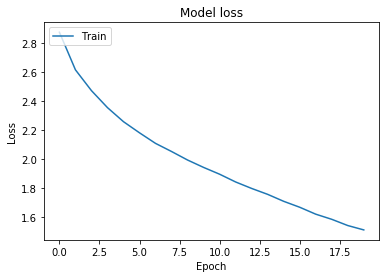

In [89]:
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

# Generate Text

In [90]:
start = np.random.randint(0, len(X_text)-1)
vocab_len = len(vocab)
pattern = X_text[start]

print(f"Seed: \n {''.join([idx2char[value] for value in pattern])}")
out = [idx2char[value] for value in pattern]

# generate characters
for i in range(100):
    x = np.reshape(pattern, (1, len(pattern), 1))
    x = x / float(vocab_len)
    prediction = model.predict(x, verbose=0)
    index = np.argmax(prediction)
    result = idx2char[index]
    in_seq = [idx2char[value] for value in pattern]
    out.append(result)
    pattern.append(index)
    pattern = pattern[1:len(pattern)]

print("\nGenerated Text:\n")
print(textwrap.fill(''.join(out), 80))

Seed: 
 wore them, these base slaves, ere yet the fight be done, pack up: down with them! and hark, what noi

Generated Text:

wore them, these base slaves, ere yet the fight be done, pack up: down with
them! and hark, what noiyes me the people, what shen? she coumd with the people,
what shen? the courte with the people, what


# Resources and Stretch Goals

## Stretch goals:
- Refine the training and generation of text to be able to ask for different genres/styles of Shakespearean text (e.g. plays versus sonnets)
- Train a classification model that takes text and returns which work of Shakespeare it is most likely to be from
- Make it more performant! Many possible routes here - lean on Keras, optimize the code, and/or use more resources (AWS, etc.)
- Revisit the news example from class, and improve it - use categories or tags to refine the model/generation, or train a news classifier
- Run on bigger, better data

## Resources:
- [The Unreasonable Effectiveness of Recurrent Neural Networks](https://karpathy.github.io/2015/05/21/rnn-effectiveness/) - a seminal writeup demonstrating a simple but effective character-level NLP RNN
- [Simple NumPy implementation of RNN](https://github.com/JY-Yoon/RNN-Implementation-using-NumPy/blob/master/RNN%20Implementation%20using%20NumPy.ipynb) - Python 3 version of the code from "Unreasonable Effectiveness"
- [TensorFlow RNN Tutorial](https://github.com/tensorflow/models/tree/master/tutorials/rnn) - code for training a RNN on the Penn Tree Bank language dataset
- [4 part tutorial on RNN](http://www.wildml.com/2015/09/recurrent-neural-networks-tutorial-part-1-introduction-to-rnns/) - relates RNN to the vanishing gradient problem, and provides example implementation
- [RNN training tips and tricks](https://github.com/karpathy/char-rnn#tips-and-tricks) - some rules of thumb for parameterizing and training your RNN